In [ ]:
!uv add -qU langgraph langchain langchain-openai

In [4]:
!uv add -q python-dotenv

In [5]:
from dotenv import load_dotenv

load_dotenv()

True

## Parallelization (병렬 처리)

### Model 정의

In [7]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-5-nano")

### State 정의

In [8]:
from typing import TypedDict

class WriterState(TypedDict):
    topic: str      # 주제
    poem: str       # 시 (결과물 A)
    story: str      # 소설 (결과물 B)
    joke: str       # 농담 (결과물 C)
    final_report: str #최종 편집본

### Node 정의

In [14]:
# [Worker A] 시인 노드
def write_poem(state: WriterState):
    topic = state['topic']
    print(f" [Worker A] '{topic}' 주제로 시(Poem) 작성 시작...")

    msg = model.invoke(f"'{topic}'에 대한 아름다운 시를 짧게 써줘.")
    return {"poem": msg.content}

In [9]:
# [Worker B] 소셜가 노드
def write_story(state: WriterState):
    topic = state["topic"]
    print(f" [Worker B] '{topic}' 주제로 소설(Story) 작성 시작...")

    msg = model.invoke(f"'{topic}'에 대한 감동적인 짧은 이야기를 써줘.")
    return {"story": msg.content}

In [10]:
# [Worker C] 개그맨 노드
def write_joke(state: WriterState):
    topic = state['topic']
    print(f" [Worker C] '{topic}' 주제로 농당(Joke) 작성 시작...")

    msg = model.invoke(f"'{topic}'에 대한 재미있는 아재개그를 하나 해줘.")
    return {"joke": msg.content}

In [ ]:
# [Aggregator] 편집장 노드 (모든 결과를 취합)
def aggregator(state: WriterState):
    print("\n--- [Aggregator] 모든 원고 도착! 최종 편집 중 ---")

    # State에 저장된 각 결과물을 꺼내서 합침
    final_text = f"""
    [주제: {state['topic']} 종합 선물세트]

    1. 시 (Poem)
    --------------
    {state['poem']}

    2. 소설 (Story)
    --------------
    {state['story']}

    3. 농담 (Joke)
    --------------
    {state['joke']}
    """
    return {"final_report": final_text}

### 그래프 생성

In [15]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(WriterState)

# 노드 추가
workflow.add_node('write_poem', write_poem)
workflow.add_node('write_story', write_story)
workflow.add_node('write_joke', write_joke)
workflow.add_node('aggregator', aggregator)

#엣지 (Fan-out)
workflow.add_edge(START, 'write_poem')
workflow.add_edge(START, 'write_story')
workflow.add_edge(START, 'write_joke')

# 하나의 노드로 모이기 (Fan-in)
workflow.add_edge('write_poem', 'aggregator')
workflow.add_edge('write_story', 'aggregator')
workflow.add_edge('write_joke', 'aggregator')

workflow.add_edge('aggregator', END)

app = workflow.compile()


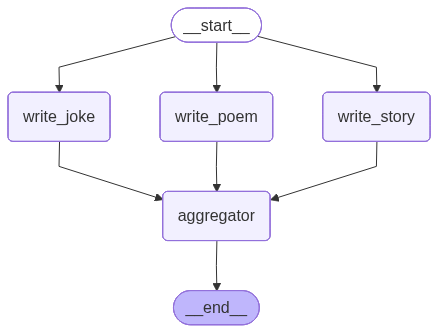

In [16]:
app

### 실행

In [17]:
inputs = {"topic": "직장인의 월요일"}
result = app.invoke(inputs)

 [Worker C] '직장인의 월요일' 주제로 농당(Joke) 작성 시작...
 [Worker A] '직장인의 월요일' 주제로 시(Poem) 작성 시작...
 [Worker B] '직장인의 월요일' 주제로 소설(Story) 작성 시작...

--- [Aggregator] 모든 원고 도착! 최종 편집 중 ---


In [18]:
result

{'topic': '직장인의 월요일',
 'poem': '월요일의 숨\n\n새벽 커피 위로 빛이 내려앉고,\n창밖 도시의 호흡이 나를 불러 세운다.\n키보드의 박동과 내 맥박이 하나가 되고,\n점심의 햇살이 어깨를 데우며 다시 시작의 기적을 속삭인다.',
 'story': '월요일은 늘 도착하는 게 힘들다. 알람 소리에 겨우 눈을 떴다. 창밖의 흐린 도시를 바라보며 커튼을 걷자, 옅은 빗방울이 창문을 두드렸다. 직장인은 매주 같은 시간에 같은 출근길을 걷는다. 오늘도 그랬다. 넥타이는 뼈대처럼 목을 조였고, 남은 힘은 커피 잔의 쓴맛으로 겨우 버티고 있었다.\n\n사무실에 들어서자 냉랭한 형광등과 잔잔한 키보드 소리가 현수를 반겨줬다. 새로 들어온 인턴 지영이 화면을 가리키며 “이거 맞나요?”라고 물었다. 현수는 천천히 앉아 그녀의 차트를 함께 정리했다. “먼저 이 표를 이렇게 정리하고, 이 주석을 간단하게 달면 돼.” 두 사람은 가볍게 머리를 맞댔다. 작은 안내 하나가 공간의 긴장을 풀었다.\n\n점심시간, 지영은 “오늘 고생 많으셨어요.”라며 건네는 미소에 현수도 미소로 응답했다. 회사의 긴장감은 여전히 남아 있었지만, 작은 대화 하나가 분위기를 부드럽게 만들었다. 현수는 누군가를 도울 때마다 묵직했던 마음이 조금씩 가벼워지는 것을 느꼈다.\n\n퇴근길에 현수는 건물 밖에서 마주친 청소 아저씨를 도왔다. 박스 하나가 계단에 걸려 움직이지 않자 함께 들어 올렸다. 아저씨는 “오늘도 감사합니다”라는 말에 고개를 푹 숙이며 웃었다. 그 짧은 마음의 교환이 현수의 가슴에 작은 불빛을 켰다. 길거리의 빗방울이 창문에 맺히며 도시에 또렷한 반짝임을 남겼다.\n\n집으로 돌아와 책상 위를 정리하던 현수는 지영의 쪽지를 발견했다. “오늘 따라 배우는 게 많았습니다. 감사합니다.” 그리고 곁에 접힌 종이학 하나가 있었다. 종이학의 날개에 작은 글씨가 적혀 있었다. “힘내요.” 현수는 그 글자를 어루만지며 속으로 다짐했다. 월요일은 언제나 벅찬 시작이지만, 오늘의 작은 친절

In [19]:
result["final_report"]

'\n    [주제: 직장인의 월요일 종합 선물세트]\n\n    1. 시 (Poem)\n    --------------\n    월요일의 숨\n\n새벽 커피 위로 빛이 내려앉고,\n창밖 도시의 호흡이 나를 불러 세운다.\n키보드의 박동과 내 맥박이 하나가 되고,\n점심의 햇살이 어깨를 데우며 다시 시작의 기적을 속삭인다.\n\n    2. 소설 (Story)\n    --------------\n    월요일은 늘 도착하는 게 힘들다. 알람 소리에 겨우 눈을 떴다. 창밖의 흐린 도시를 바라보며 커튼을 걷자, 옅은 빗방울이 창문을 두드렸다. 직장인은 매주 같은 시간에 같은 출근길을 걷는다. 오늘도 그랬다. 넥타이는 뼈대처럼 목을 조였고, 남은 힘은 커피 잔의 쓴맛으로 겨우 버티고 있었다.\n\n사무실에 들어서자 냉랭한 형광등과 잔잔한 키보드 소리가 현수를 반겨줬다. 새로 들어온 인턴 지영이 화면을 가리키며 “이거 맞나요?”라고 물었다. 현수는 천천히 앉아 그녀의 차트를 함께 정리했다. “먼저 이 표를 이렇게 정리하고, 이 주석을 간단하게 달면 돼.” 두 사람은 가볍게 머리를 맞댔다. 작은 안내 하나가 공간의 긴장을 풀었다.\n\n점심시간, 지영은 “오늘 고생 많으셨어요.”라며 건네는 미소에 현수도 미소로 응답했다. 회사의 긴장감은 여전히 남아 있었지만, 작은 대화 하나가 분위기를 부드럽게 만들었다. 현수는 누군가를 도울 때마다 묵직했던 마음이 조금씩 가벼워지는 것을 느꼈다.\n\n퇴근길에 현수는 건물 밖에서 마주친 청소 아저씨를 도왔다. 박스 하나가 계단에 걸려 움직이지 않자 함께 들어 올렸다. 아저씨는 “오늘도 감사합니다”라는 말에 고개를 푹 숙이며 웃었다. 그 짧은 마음의 교환이 현수의 가슴에 작은 불빛을 켰다. 길거리의 빗방울이 창문에 맺히며 도시에 또렷한 반짝임을 남겼다.\n\n집으로 돌아와 책상 위를 정리하던 현수는 지영의 쪽지를 발견했다. “오늘 따라 배우는 게 많았습니다. 감사합니다.” 그리고 곁에 접힌 종이학 하나가 있었다. 종이학의 날개에 작